In [3]:
import csv
import json

condition_mapping_file = "./resources/CCSCM.csv"
procedure_mapping_file = "./resources/CCSPROC.csv"
drug_file = "./resources/ATC.csv"

condition_dict = {}
with open(condition_mapping_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        condition_dict[row['code']] = row['name'].lower()

procedure_dict = {}
with open(procedure_mapping_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        procedure_dict[row['code']] = row['name'].lower()

drug_dict = {}
with open(drug_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['level'] == '5.0':
            drug_dict[row['code']] = row['name'].lower()

In [4]:
from pyhealth.datasets import MIMIC3Dataset, MIMIC4Dataset
from GraphCare.task_fn import drug_recommendation_mimic4_fn

mimic4_ds = MIMIC4Dataset(
    root="../../../data/physionet.org/files/mimiciv/2.0/hosp/", 
    tables=["DIAGNOSES_ICD", "PROCEDURES_ICD", "PRESCRIPTIONS"],      
    code_mapping={
        "NDC": ("ATC", {"target_kwargs": {"level": 3}}),
        "ICD9CM": "CCSCM",
        "ICD9PROC": "CCSPROC",
        "ICD10CM": "CCSCM",
        "ICD10PROC": "CCSPROC",
        },
    dev=True
)

sample_dataset = mimic4_ds.set_task(drug_recommendation_mimic4_fn)

Generating samples for drug_recommendation_mimic4_fn: 100%|██████████| 11925/11925 [00:01<00:00, 8987.41it/s]


In [5]:
def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

In [6]:
from pyhealth.tokenizer import Tokenizer
import numpy as np
from tqdm import tqdm
import torch

def multihot(label, num_labels):
    multihot = np.zeros(num_labels)
    for l in label:
        multihot[l] = 1
    return multihot

def prepare_label(drugs):
    label_tokenizer = Tokenizer(
        sample_dataset.get_all_tokens(key='drugs')
    )

    labels_index = label_tokenizer.convert_tokens_to_indices(drugs)
    # print(labels_index)
    # convert to multihot
    num_labels = label_tokenizer.get_vocabulary_size()
    # print(num_labels)
    labels = multihot(labels_index, num_labels)
    return labels


for patient in tqdm(sample_dataset):
    # patient['drugs_all'] = flatten(patient['drugs'])
    # print(patient['drugs_all'])
    patient['drugs_ind'] = torch.tensor(prepare_label(patient['drugs']))

100%|██████████| 9582/9582 [03:33<00:00, 44.93it/s]


In [7]:
import pickle
import json
from tqdm import tqdm
import numpy as np
import networkx as nx

# with open('./exp_data/ccscm_ccsproc/sample_dataset.pkl', 'rb') as f:
#     sample_dataset= pickle.load(f)
with open('./graphs/cond_proc/CCSCM_CCSPROC/ent2id.json', 'r') as file:
    ent2id = json.load(file)
with open('./graphs/cond_proc/CCSCM_CCSPROC/rel2id.json', 'r') as file:
    rel2id = json.load(file)
with open('./graphs/cond_proc/CCSCM_CCSPROC/entity_embedding.pkl', 'rb') as file:
    ent_emb = pickle.load(file)
with open('./graphs/cond_proc/CCSCM_CCSPROC/relation_embedding.pkl', 'rb') as file:
    rel_emb = pickle.load(file)

In [3]:
ent_emb[0]

array([-0.02357265,  0.002313  ,  0.02204529, ..., -0.01157682,
        0.01255   ,  0.00188047])

In [6]:
import pickle

with open('/data/pj20/exp_data/ccscm_ccsproc/sample_dataset_drugrec_th015.pkl', 'rb') as f:
    sample_dataset = pickle.load(f)

/home/pj20/miniconda3/envs/kgc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score

# perform DBSCAN clustering with the best parameters
clustering = DBSCAN(eps=0.08, min_samples=1, metric='cosine').fit(ent_emb)

In [5]:
from sklearn.cluster import AgglomerativeClustering

# Set up the hierarchical clustering algorithm
cluster_alg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.15, linkage='average', affinity='cosine')
# Fit the algorithm to your data
cluster_labels = cluster_alg.fit_predict(ent_emb)

/home/pj20/miniconda3/envs/kgc/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [9]:
len(ent_emb), len(cluster_labels)

(19347, 19347)

In [15]:
len(np.unique(cluster_labels))

589

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Create the linkage matrix
Z = linkage(cluster_alg.children_, method='ward')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(15, 5))
dendrogram(Z, truncate_mode='level', p=5, ax=ax)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [18]:
from collections import defaultdict
import json

def nested_dict():
    return defaultdict(list)

map_cluster = defaultdict(nested_dict)

for unique_l in np.unique(cluster_labels):
    for cur in range(len(cluster_labels)):
        if cluster_labels[cur] == unique_l:
            map_cluster[str(unique_l)]['nodes'].append(cur)

# map_cluster = defaultdict(nested_dict)
# i = 0
# for key in map_cluster_.keys():
#     if len(map_cluster_[key]['nodes']) > 50:
#         for node in map_cluster_[key]['nodes']:
#             map_cluster[str(i)]['nodes'] = [node]
#             i+=1
#     else:
#         map_cluster[str(i)]['nodes'] = map_cluster_[key]['nodes']
#         i+=1

for unique_l in map_cluster.keys():
    nodes = map_cluster[unique_l]['nodes']
    nodes = np.array(nodes)
    embedding_mean = np.mean(ent_emb[nodes], axis=0)
    map_cluster[unique_l]['embedding'].append(embedding_mean.tolist())

map_cluster_inv = {}
for cluster_label, item in map_cluster.items():
    for node in item['nodes']:
        map_cluster_inv[str(node)] = cluster_label

In [19]:
with open('./exp_data/ccscm_ccsproc/clusters.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster, f, indent=6)

with open('./exp_data/ccscm_ccsproc/clusters_inv.json', 'w', encoding='utf-8') as f:
    json.dump(map_cluster_inv, f, indent=6)

In [50]:
## read and store node set for each patient
for patient in tqdm(sample_dataset): 
    triple_set = set()
    node_set = set()
    conditions = flatten(patient['conditions'])
    for condition in conditions:
        cond_file = f'./graphs/condition/CCSCM/{condition}.txt'
        with open(cond_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triple_set.add(triple)
                    node_set.add(int(map_cluster_inv[h]))
                    # node_set.add(r)
                    node_set.add(int(map_cluster_inv[t]))

    procedures = flatten(patient['procedures'])
    for procedure in procedures:
        proc_file = f'./graphs/procedure/CCSPROC/{procedure}.txt'
        with open(proc_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triple_set.add(triple)
                    node_set.add(int(map_cluster_inv[h]))
                    # node_set.add(r)
                    node_set.add(int(map_cluster_inv[t]))
        
    patient['node_set'] = node_set

100%|██████████| 44399/44399 [01:46<00:00, 416.15it/s]


In [51]:
import pickle

with open('./exp_data/ccscm_ccsproc/sample_dataset_drugrec.pkl', 'wb') as f:
    pickle.dump(sample_dataset, f)

In [52]:
G = nx.Graph()

for cluster_label, item in map_cluster.items():
    G.add_nodes_from([
        (int(cluster_label), {'y': int(cluster_label), 'x': item['embedding'][0]})
    ])

# for i in range(len(rel_emb)):
#     G.add_nodes_from([
#         (i+len(ent_emb), {'y': i+len(ent_emb), 'x': rel_emb[i]})
#     ])

triples_all = []
for patient in tqdm(sample_dataset):
    triples = []
    triple_set = set()
    # node_set = set()
    conditions = flatten(patient['conditions'])
    for condition in conditions:
        cond_file = f'./graphs/condition/CCSCM/{condition}.txt'
        with open(cond_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triples.append((int(map_cluster_inv[h]), int(map_cluster_inv[t])))
                    triple_set.add(triple)
                    # node_set.add(h)
                    # node_set.add(r)
    procedures = flatten(patient['procedures'])
    for procedure in procedures:
        proc_file = f'./graphs/procedure/CCSPROC/{procedure}.txt'
        with open(proc_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            items = line.split('\t')
            if len(items) == 3:
                h, r, t = items
                t = t[:-1]
                h = ent2id[h]
                # r = int(rel2id[r]) + len(ent_emb)
                t = ent2id[t]
                triple = (h, r, t)
                if triple not in triple_set:
                    triples.append((int(map_cluster_inv[h]), int(map_cluster_inv[t])))
                    triple_set.add(triple)

    G.add_edges_from(
        triples,
        # label=prepare_label(patient['drugs'])
    )
    
    # triples.append(prepare_label(patient['drugs']))
    # triples_all.append(np.array(triples))


100%|██████████| 44399/44399 [02:19<00:00, 317.16it/s]


In [54]:
from torch_geometric.utils import to_networkx, from_networkx
import pickle

with open('./exp_data/ccscm_ccsproc/graph_pd.pkl', 'wb') as f:
    pickle.dump(G, f)

In [2]:
import json

with open('./exp_data/ccscm_ccsproc/clusters.json', 'r', encoding='utf-8') as f:
    map_cluster = json.load(f)

with open('./exp_data/ccscm_ccsproc/clusters_inv.json', 'r', encoding='utf-8') as f:
    map_cluster_inv = json.load(f)

In [3]:
type(ent_emb)

numpy.ndarray

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# apply t-SNE to reduce the dimensionality to 2
tsne = TSNE(n_components=2, random_state=42)
word_embeddings_tsne = tsne.fit_transform(ent_emb)
# get the embeddings as a numpy array
node_embeddings = np.array([node['x'] for _, node in G.nodes(data=True)])

plot_we = []
plot_clus = []
for key in map_cluster.keys():
    # if len(map_cluster[key]['nodes']) > 5:
    plot_we.append(np.array(map_cluster[key]['nodes']))
    plot_clus.append(np.array(map_cluster[key]['embedding']))
plot_clus = np.array(plot_clus)

plot_clus = plot_clus.reshape((plot_clus.shape[0], plot_clus.shape[2]))
clus_embeddings_tsne = tsne.fit_transform(plot_clus)


: 

: 

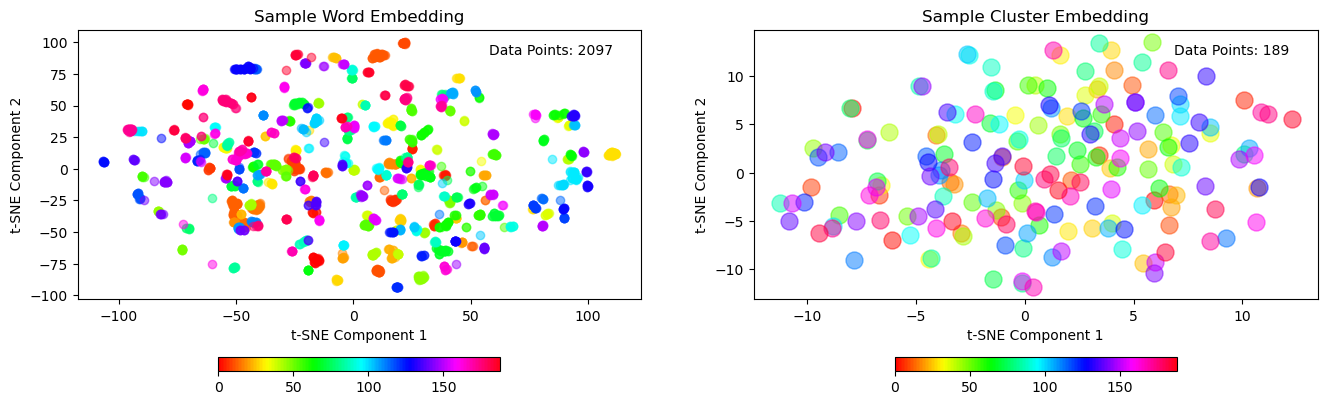

In [88]:
# plot the result in 3D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
# create a colormap for the clusters

colormap = plt.cm.get_cmap('hsv', len(plot_we))

for i in range(len(plot_we)):
    ax1.scatter(word_embeddings_tsne[plot_we[i], 0], word_embeddings_tsne[plot_we[i], 1], alpha=0.5, c=[colormap(i)])
# ax.scatter(word_embeddings_tsne[clustering.labels_ == -1, 0], word_embeddings_tsne[clustering.labels_ == -1, 1], word_embeddings_tsne[clustering.labels_ == -1, 2], label='Noise', color='gray', alpha=0.2)

# add the color bar
sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_array([i for i in range(len(plot_we))])
cbar = plt.colorbar(sm, ax=ax1, shrink=0.5, orientation='horizontal')

ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_title('Sample Word Embedding')

colormap = plt.cm.get_cmap('hsv', len(plot_clus))

for i in range(len(plot_clus)):
    ax2.scatter(clus_embeddings_tsne[i, 0], clus_embeddings_tsne[i, 1], alpha=0.5, c=[colormap(i)], s=150)
# ax.scatter(word_embeddings_tsne[clustering.labels_ == -1, 0], word_embeddings_tsne[clustering.labels_ == -1, 1], word_embeddings_tsne[clustering.labels_ == -1, 2], label='Noise', color='gray', alpha=0.2)

# add the color bar
sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_array([i for i in range(len(plot_clus))])
cbar = plt.colorbar(sm, ax=ax2, shrink=0.5, orientation='horizontal')

ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_title('Sample Cluster Embedding')

p_cnt = 0
for we in plot_we:
    p_cnt += len(we)

ax1.text(0.95, 0.95, f"Data Points: {p_cnt}", transform=ax1.transAxes, ha='right', va='top')
ax2.text(0.95, 0.95, f"Data Points: {len(plot_clus)}", transform=ax2.transAxes, ha='right', va='top')

# save the plot as a PDF
plt.savefig('clus.pdf', format='pdf')

plt.show()

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

# Active tuberculosis, tuberculosis
similarity = cosine_similarity([ent_emb[133], ent_emb[4097]])
print(similarity)

# tuberculosis lesions in lungs, tuberculosis
similarity = cosine_similarity([ent_emb[4497], ent_emb[4097]])
print(similarity)

similarity = cosine_similarity([ent_emb[8156], ent_emb[6252]])
print(similarity)


[[1.         0.84411807]
 [0.84411807 1.        ]]
[[1.         0.85945057]
 [0.85945057 1.        ]]
[[1.         0.85283494]
 [0.85283494 1.        ]]
